In [1]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-05-10 14:03:29--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  19.8MB/s    in 11s     

2020-05-10 14:03:41 (15.3 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-05-10 14:03:41--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  15.2MB/s    in 5.9s    

2020-05-10 14:03:48 (10.4 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [0]:
from scipy.io import loadmat
svhn_train = loadmat('train_32x32.mat')
svhn_test = loadmat('test_32x32.mat')

(32, 32, 3, 73257)

(73257, 1)

array([1], dtype=uint8)

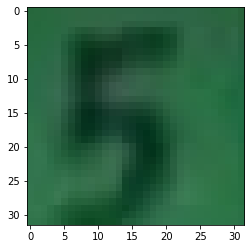

In [77]:
import matplotlib.pyplot as plt
svhn_x_train = svhn_train['X']
svhn_y_train = svhn_train['y']
svhn_x_test = svhn_test['X']
svhn_y_test = svhn_test['y']
display(svhn_x_train.shape)
display(svhn_y_train.shape)
plt.imshow(svhn_x_test[:,:,:,0])
display(svhn_y_train[0])


(73257, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


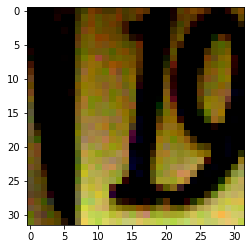

In [50]:
import numpy as np
x_train = svhn_x_train
x_test = svhn_x_test
y_test = svhn_y_test
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_train = np.moveaxis(x_train, 3, 0)
x_test = np.moveaxis(x_test, 3, 0)
display(x_train.shape)
plt.imshow(x_train[0]+1)

In [85]:
import keras
y_train = svhn_y_train[:,:]-1
y_test = svhn_y_test[:,:]-1
y_train_categorical = keras.utils.to_categorical(y_train)
y_test_categorical = keras.utils.to_categorical(y_test)
display(y_train_categorical.shape)
display(y_test_categorical.shape)

(73257, 10)

(26032, 10)

In [47]:
from keras import models, layers, regularizers, optimizers

def make_model1():
  model = models.Sequential()
  model.add(layers.Conv2D(filters=16,kernel_size=3,padding='same',activation='relu',input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(500,activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(10,activation='softmax'))

def make_model2():
  base_hidden_units = 32
  weight_decay = 1e-4
  model = models.Sequential()

  # CONV1
  model.add(
    layers.Conv2D(
      base_hidden_units,
      kernel_size=3,
      padding='same',
      kernel_regularizer = regularizers.l2(weight_decay),
      input_shape=x_train.shape[1:4]
    )
  )
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())

  # CONV2
  model.add(
    layers.Conv2D(
      base_hidden_units,
      kernel_size=3,
      padding='same',
      kernel_regularizer=regularizers.l2(weight_decay)
    )
  )
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())

  # POOL + Dropout
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.2))

  # CONV3
  model.add(
    layers.Conv2D(
      base_hidden_units*2,
      kernel_size=3,
      padding='same',
      kernel_regularizer=regularizers.l2(weight_decay)
    )
  )
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())

  # CONV4
  model.add(
    layers.Conv2D(
      base_hidden_units*2,
      kernel_size=3,
      padding='same',
      kernel_regularizer=regularizers.l2(weight_decay)
    )
  )
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())

  # POOL + Dropout
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.3))

  # Conv5
  model.add(
    layers.Conv2D(
      base_hidden_units*4,
      kernel_size=3,
      padding='same',
      kernel_regularizer=regularizers.l2(weight_decay)
    )
  )
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())

  # Conv6
  model.add(
    layers.Conv2D(
      base_hidden_units*4,
      kernel_size=3,
      padding='same',
      kernel_regularizer=regularizers.l2(weight_decay)
    )
  )
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.3))

  # layer 7: Fully Connected
  model.add(layers.Flatten())
  model.add(layers.Dense(10, activation='softmax'))
  return model

model = make_model2()
display(model.summary())
optimizer=optimizers.adam(learning_rate=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])




Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)       

None

In [86]:
from keras import callbacks, preprocessing
batch_size=128
checkpointer=callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5',verbose=1,save_best_only=True)
n_validation_samples=5000
display(x_train.shape[0])
datagen = preprocessing.image.ImageDataGenerator(
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True,
  vertical_flip=False
)
# compute the data augmentation on the training set
datagen.fit(x_train)
hist=model.fit_generator(
    generator=datagen.flow(
        x_train[n_validation_samples:],
        y_train_categorical[n_validation_samples:],
        batch_size=batch_size
    ),
    validation_data=(x_train[:n_validation_samples],y_train_categorical[:n_validation_samples]),
    steps_per_epoch=(x_train.shape[0] // batch_size),
    epochs=125,
    callbacks=[checkpointer],
    verbose=2
)

73257

Epoch 1/125
 - 61s - loss: 2.8494 - accuracy: 0.1987 - val_loss: 1.8235 - val_accuracy: 0.3820

Epoch 00001: val_loss improved from inf to 1.82346, saving model to model.weights.best.hdf5
Epoch 2/125
 - 53s - loss: 2.0764 - accuracy: 0.3679 - val_loss: 1.3121 - val_accuracy: 0.5738

Epoch 00002: val_loss improved from 1.82346 to 1.31213, saving model to model.weights.best.hdf5
Epoch 3/125
 - 54s - loss: 1.7054 - accuracy: 0.4692 - val_loss: 0.9873 - val_accuracy: 0.6864

Epoch 00003: val_loss improved from 1.31213 to 0.98728, saving model to model.weights.best.hdf5
Epoch 4/125
 - 53s - loss: 1.4177 - accuracy: 0.5576 - val_loss: 0.8115 - val_accuracy: 0.7566

Epoch 00004: val_loss improved from 0.98728 to 0.81153, saving model to model.weights.best.hdf5
Epoch 5/125
 - 54s - loss: 1.2112 - accuracy: 0.6190 - val_loss: 0.6658 - val_accuracy: 0.8012

Epoch 00005: val_loss improved from 0.81153 to 0.66577, saving model to model.weights.best.hdf5
Epoch 6/125
 - 54s - loss: 1.0663 - accuracy

KeyboardInterrupt: ignored

In [0]:
model.save('temp_model.h5')

In [88]:
plt.plot(hist.history['val_accuracy'])

NameError: ignored

In [90]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test_categorical, verbose=1)
score


26032/26032 [==============================] - 9s 364us/step


[0.2792073027187868, 0.9326213598251343]